# The CheaaMan dataset is a kaggle dataset which consists of Chess piece images. 

In this Jupyter notebook we are building a image classification model to classify different Chess pieces.
The Jupyter Notebook involves,
- Image Preprocessing
- Data Augumentstion

Kaggle dataset url: https://www.kaggle.com/niteshfre/chessman-image-dataset

In [1]:
from os import listdir
from os.path import isfile, join

data_path = "./Data/Chessman-image-dataset/Chess/"

folder_names = [f for f in listdir(data_path)]
img_extention = set()
for folder in folder_names:
    for images in listdir(data_path+folder):
        extention = (images.split('.')[-1]).lower()
        img_extention.add(extention)
print(folder_names)
print(img_extention)

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
{'jpeg', 'png', 'gif', 'jpg', 'fcgi'}


The image dataset is spread across various classes such as 'Bishop', 'King', etc. If we notice the image format varies much, but as all the image formats are readable in python we are proceeding further.

# Data Augumentation

We are performing Data Augumentation on the available data as our image dataset is comparitively lesser and not sufficient for our CNN model training. It is also done to aid in avoiding overfitting problem.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
datagen = ImageDataGenerator(rotation_range=15, 
                             fill_mode='nearest', 
                             shear_range = 0.1,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True, 
                             #vertical_flip=True, 
                             brightness_range=[0.4,0.8], 
                             zoom_range=0.1)

In [7]:
# ImageDataGenerator flow_from_directory

train_generator = datagen.flow_from_directory(
                  #save_to_dir = DataAgumentationPath+"train/",
                  directory=data_path,
                  target_size=(128, 128), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode='categorical', # classes to predict
                  seed=2020 # to make the result reproducible
                  )

preprecessed_test_data_path = "./PreProcessData/Test/"
test_generator = datagen.flow_from_directory(
                  directory=preprecessed_test_data_path,
                  #save_to_dir = DataAgumentationPath+"test/",
                  target_size=(128, 128), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode='categorical', # classes to predict
                  seed=2020 # to make the result reproducible
                  )

Found 553 images belonging to 6 classes.
Found 32 images belonging to 6 classes.


### Creating Train and Test data sets using Data Augumentation

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x_train = []
y_train = []
for i in range(20000):
    iterator = next(train_generator)
    img = iterator[0].astype('uint8')/255.
    category = iterator[1]
    #print("img : ",img)
    x_train.append(img[0])
    y_train.append(category[0])

In [9]:
x_train
x_train = np.array(x_train)
x_train.shape

(20000, 128, 128, 3)

In [60]:
y_train = np.array(y_train)
y_train.shape

(20000, 6)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x_test = []
y_test = []
for i in range(4000):
    iterator = next(test_generator)
    img = iterator[0].astype('uint8')/255.
    category = iterator[1]
    x_test.append(img[0])
    y_test.append(category[0])

In [12]:
x_test = np.array(x_test)
x_test.shape

(4000, 128, 128, 3)

In [13]:
y_test = np.array(y_test)
y_test.shape

(4000, 6)

# Model Creation and Training

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(folder_names),activation='softmax'))

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model/ChessMan_Classifier_model.h5",
                            monitor='val_loss',
                            mode='min',
                            save_best_model=True,
                            verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0,
                         patience = 3,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=3,
                             verbose=1,
                             min_delta=0.0001)

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0

In [18]:
history = model.fit(x_train,y_train,
                    epochs=15,
                    validation_data=(x_test,y_test),
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 1.5954 - accuracy: 0.3399
Epoch 00001: saving model to ./model\ChessMan_Classifier_model.h5
625/625 [==============================] - 825s 1s/step - loss: 1.5954 - accuracy: 0.3399 - val_loss: 1.4381 - val_accuracy: 0.4445
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 0.9415 - accuracy: 0.6459
Epoch 00002: saving model to ./model\ChessMan_Classifier_model.h5
625/625 [==============================] - 824s 1s/step - loss: 0.9415 - accuracy: 0.6459 - val_loss: 1.1809 - val_accuracy: 0.6248
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.8293
Epoch 00003: saving model to ./model\ChessMan_Classifier_model.h5
625/625 [==============================] - 834s 1s/step - loss: 0.4695 - accuracy: 0.8293 - val_loss: 1.3033 - val_accuracy: 0.6630
Epoch 4/15
625/625 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9095
Epoch 00004: saving mo

The model has stopped further training as the model performance did not improve. This was done by Early Stopping. We have saved the best model.

actual :  Bishop
Predicted :  Bishop 

actual :  Pawn
Predicted :  Pawn 

actual :  King
Predicted :  King 

actual :  Pawn
Predicted :  Pawn 

actual :  Knight
Predicted :  Knight 



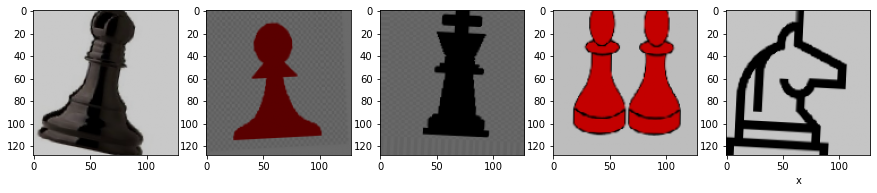

In [58]:
class_list = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
    iterator = next(test_generator)
    img = iterator[0].astype('uint8')/255.
    ax[i].imshow(np.squeeze(img))
    plt.xlabel("x")
    category = iterator[1]
    print("actual : ",class_list[np.argmax(category)])
    print("Predicted : ",class_list[np.argmax(model.predict(img)[0])], "\n")
    